In [0]:
#%matplotlib notebook
#%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
signal_length = 15
signal_repeats = 3
predict_ahead = 1
noise_strength = 0.00
total_series_length = signal_length * signal_repeats

Input: sinus signal $\sin(x_t)$

Target: same signal but predict_ahead steps ($\delta$) shifted (predict to future) $\sin(x_{t+\delta})$

In [0]:
dims = 1
def generateData(signal_length, predict_ahead, signal_repeats, batch_size, noise_strength):
    total_series_length = signal_length*signal_repeats
    x = np.linspace(0, np.pi*2*signal_repeats, total_series_length + predict_ahead, dtype=np.float32)
    x = x.reshape((1, -1, 1))  
    
    # include shift for batches
    x = np.repeat(x, batch_size, 0)
    x += np.random.random(batch_size)[:, None, None] * 10
    y = np.sin(x)
    input_ = y[:, :total_series_length].copy()
    if noise_strength > 0:
        input_ += np.random.normal(size=(input_.shape)) * noise_strength # add some noise to the input
    target = y[:, predict_ahead:]
    return input_ , target 

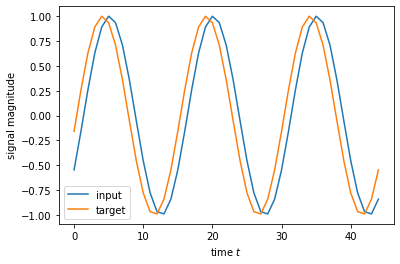

In [19]:
x, y = generateData(signal_length, predict_ahead, signal_repeats, 1, noise_strength)
x_i, y_i = x[0, :, 0], y[0, :, 0]
f, ax = plt.subplots(1)
ax.plot(x_i, label="input")
ax.plot(y_i, label="target")
ax.set_xlabel("time $t$")
ax.set_ylabel("signal magnitude")
ax.legend()

## Creating a SRN model

In [0]:
# use the hidden state (True) by activating learning for U_h
rnn_mode = True
# learn a better initial hidden state representation (True) than zero init
learn_h0 = True
# number of weight update iterations
n_iterations = 250
# size and stride of window for truncated backprop through time 
truncated_backprop_length = 15
# number of neurons m in the hidden layer
num_neurons = 8
batch_size = 5
lr = 0.01

first, initialize the learnable weights and biases (parameters):

parameters of the (recurrent) hidden layer

In [0]:
W_f = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
b_f = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
U_f = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
W_i = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
b_i = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
U_i = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
W_j = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
b_j = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
U_j = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
W_o = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
b_o = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
U_o = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)


# initial hidden state
h_0 = tf.Variable(np.zeros((1, num_neurons), dtype=np.float32))
c_0 = tf.Variable(np.zeros((1, num_neurons), dtype=np.float32))

parameters of the (fully-connected) output layer

In [0]:
W_y = tf.Variable(np.random.rand(num_neurons, dims), dtype=tf.float32)
b_y = tf.Variable(np.zeros((1, dims)), dtype=tf.float32)

create the forward pass for a single time step and an itertions function

$ \mathbf{h}_t \leftarrow \sigma_h \bigl( W_h \cdot \mathbf{x}_t + U_h \cdot \mathbf{h}_{t-1} + \mathbf{b}_h \bigr) $

$ \hat{\mathbf{y}}_t \leftarrow \sigma_y \bigl( W_y \cdot \mathbf{h}_t + \mathbf{b}_y \bigr) $

In [0]:
@tf.function
def step(x_t, h, c):
    # forget layer
    f = tf.nn.sigmoid(
        tf.matmul(x_t, W_f) + tf.matmul(h, U_f) + b_f
    )
    # input layer:
    i = tf.nn.sigmoid(
        tf.matmul(x_t, W_i) + tf.matmul(h, U_i) + b_i
    )
    # modulation layer:
    j = tf.nn.tanh(
        tf.matmul(x_t, W_j) + tf.matmul(h, U_j) + b_j
    )
    # output layer:
    o = tf.nn.sigmoid(
        tf.matmul(x_t, W_o) + tf.matmul(h, U_o) + b_o
    )
    # memory (cell) layer:
    c = tf.math.multiply(f,c) + tf.math.multiply(i,j)
    # hidden state 
    h = tf.math.multiply(o, tf.nn.tanh(c))
    # fully connected
    y_hat = tf.matmul(h, W_y) + b_y
    return y_hat, h, c

@tf.function
def iterate_series(x, h, c):
    y_hat = []
    # iterate over time axis (1)
    for j in range(x.shape[1]):
        # give previous hidden state and input from the current time step
        y_hat_t, h, c = step(x[:, j], h, c)
        y_hat.append(y_hat_t)
    y_hat = tf.stack(y_hat, 1)
    return y_hat, h, c

for backpropagation we use Adam, but we could use any optimizer from tf.keras.optimizer (or write our own)

In [0]:
# define which parameters get updated during the gradient step
# backpropagation
trainable_vars = [W_f, U_f, b_f, W_i, U_i, b_i, W_j, U_j, b_j, W_o, U_o, b_o]
trainable_vars.append(h_0)
trainable_vars.append(c_0)

# standard optimizer SGD or AdaGrad would also work
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

## Training the model

In [0]:
# just a helper function to see the progress
def replot(input_series, predictions_series, batchY, f, ax,  input_line, y_line, pred_line, text, iteration, loss):
    y_line.set_xdata(range(total_series_length))
    y_line.set_ydata(batchY)
    pred_line.set_xdata(range(total_series_length))
    pred_line.set_ydata(predictions_series)
    input_line.set_xdata(range(total_series_length))
    input_line.set_ydata(input_series)
    text.set_text(f"Iteration: {iteration} Loss: {loss}")
#     plt.pause(0.25)
    
    # Need both of these in order to rescale
    ax.relim()
    ax.autoscale_view()
    # We need to draw and flush
    f.canvas.draw()
    f.canvas.flush_events()

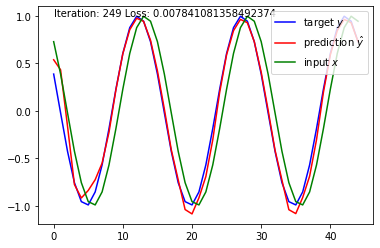

In [30]:
# training
plt.ion()
f, ax = plt.subplots(1)
y_line, = ax.plot([],[], color="blue", label="target $y$")
pred_line, = ax.plot([],[], color="red", label="prediction $\haty$")
input_line, = ax.plot([],[], color="green", label="input $x$")
text = ax.text(0, 1, "", )
ax.legend(loc='upper right')

# train for a set number of iterations
for iteration in range(n_iterations):
    # generates a long time series / normally loaded from dataset (e.g. stocks, weather)
    x, y = generateData(signal_length, predict_ahead, signal_repeats, batch_size, noise_strength)
    h = None
    predictions = None
    loss_list = []
    grads = None
    
    # do not feed complete series, but chunks of it (truncated_backprop_length)
    for i in range(0, total_series_length, truncated_backprop_length):
        
        with tf.GradientTape() as tape:
            if h is None:
                # initialize hidden state (h_0) -> new shape (batch_size, num_neurons)
                h = tf.repeat(h_0, batch_size, 0)
                c = tf.repeat(c_0, batch_size, 0) #added
            x_part = x[:, i: i + truncated_backprop_length]
            y_part = y[:, i: i + truncated_backprop_length]
            
            # get predictions for this part (forward pass)
            y_hat, h, c = iterate_series(x_part, h, c)
            #print("HLIST SHAPE", y_hat.shape)
        
            # calculate mean squared error
            loss = tf.reduce_mean((y_hat - y_part)**2)        
        # backprop
        if grads is None:
            grads = tape.gradient(loss, trainable_vars)
        else:
            grads = grads + tape.gradient(loss, trainable_vars)
                           
        loss_list.append(loss)
        # combine with previous predictions
        predictions = tf.concat([predictions, y_hat], 1) if predictions is not None else y_hat
    
    # finally we are adapting the weights
    optimizer.apply_gradients(zip(grads, trainable_vars))
        
#     print("Iteration", iteration, "Loss", np.mean(loss_list))  
    replot(x[0], predictions[0], y[0], f, ax, input_line, y_line, pred_line, text, iteration, np.mean(loss_list))

In [27]:
predictions.shape

TensorShape([5, 45, 1])

# Free Running RNN (Generating)
to make continous predictions 

In [0]:
# def free_running(x_0, h, time_steps):
#     y_hat = []
#     y_hat_t = x_0
#     # iterate over time axis (1)
#     for t in range(time_steps):
#         # give previous hidden state and input from the current time step
#         y_hat_t, h = step(y_hat_t, h)
#         y_hat.append(y_hat_t)
#     y_hat = tf.stack(y_hat, 1)
#     return y_hat, h

In [0]:
# batch_s = 1
# # initialize hidden state (h_0) with zeros
# h_ar = tf.repeat(h_0, batch_size, 0)

# # initial (single) value for x
# x_0 = np.random.uniform(-1, 1, size=(batch_s, 1)).astype(np.float32)

# # any length possible here
# length = 35
# # get predictions for "lenght" time steps (can be seen as forecast that is as long as the defined length)
# y_hat, h_ar = free_running(x_0, h_ar, length)

# f, ax = plt.subplots(1)
# ax.plot(y_hat[0, :, 0])


# Further Reading
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
* https://www.cs.utoronto.ca/~ilya/pubs/ilya_sutskever_phd_thesis.pdf

TBPTT:
* https://web.stanford.edu/class/psych209a/ReadingsByDate/02_25/Williams%20Zipser95RecNets.pdf
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.56.7941&rep=rep1&type=pdf